### Core 7
## DBSCAN (Core)
### Descripción:

En esta actividad, implementarás el algoritmo DBSCAN para detectar patrones de agrupamiento y encontrar clientes atípicos en el dataset «Wholesale Customers Data» disponible en Kaggle. DBSCAN es ideal para detectar clusters de forma arbitraria y encontrar puntos atípicos (outliers), lo que es útil en escenarios donde los datos no forman clusters esféricos como en el caso de K-means.

Enlace al dataset: https://www.kaggle.com/binovi/wholesale-customers-data

### Objetivo:

El objetivo principal de esta actividad es aplicar el algoritmo DBSCAN para identificar clusters y clientes atípicos en el dataset. El enfoque está en comprender cómo DBSCAN maneja los outliers y su capacidad para detectar agrupamientos densos.

### Instrucciones:

1. Carga de datos:
  * Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
  * El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.

In [1]:
# Importar las librerías necesarias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/Wholesale_customers_data.csv')
# Revisamos las primeras columnas para corroborar que cargo bien el dataset
df.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


2. Exploración y preprocesamiento de datos:
  * Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.
  * Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.
  * Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.

In [ ]:
# Revisar tipos de datos
print(df.dtypes)

# Contamos cuantos valores nulos existen por columna
cantNulos = df.isnull().sum()
print(f'Valores nulos en el Dataset:\n{cantNulos}')

# Exploramos las estadisticas del dataset completo. Usamos .T Para verificar los datos de una forma mas cómoda
descripcionDataset = df.describe()
print(f'Distribución estadística de los datos:\n{descripcionDataset}')

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object
Valores nulos en el Dataset:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Distribución estadística de los datos:
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755

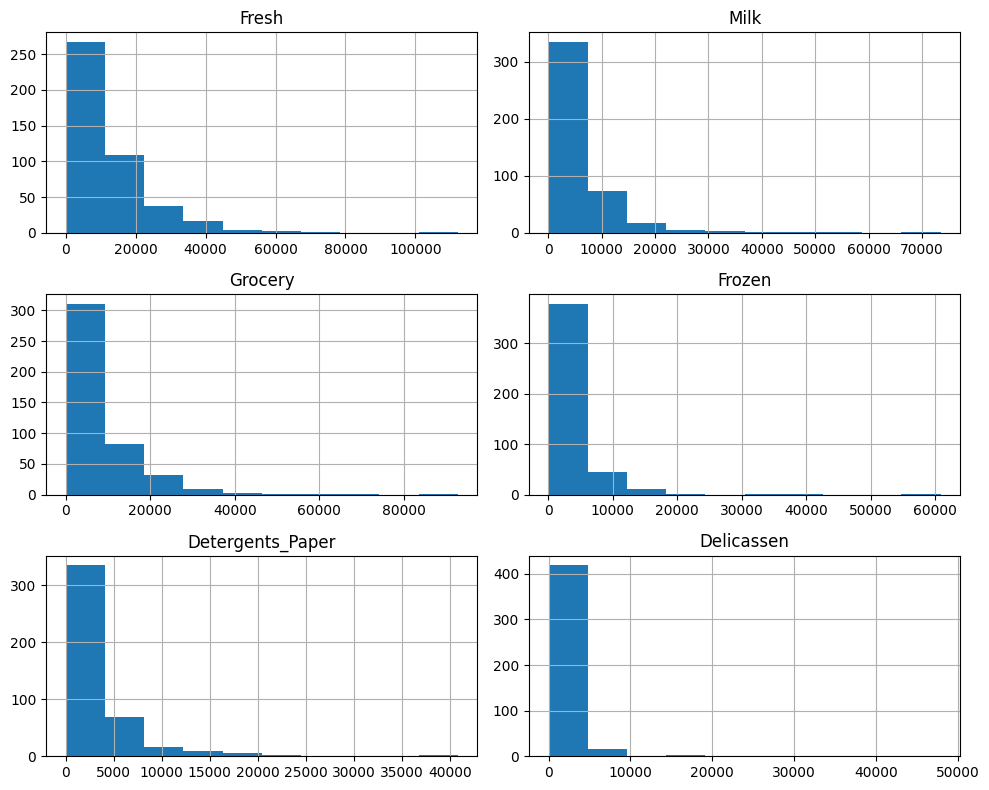

In [5]:
# Graficar histogramas de cada columna
df.drop(['Channel', 'Region'], axis=1).hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

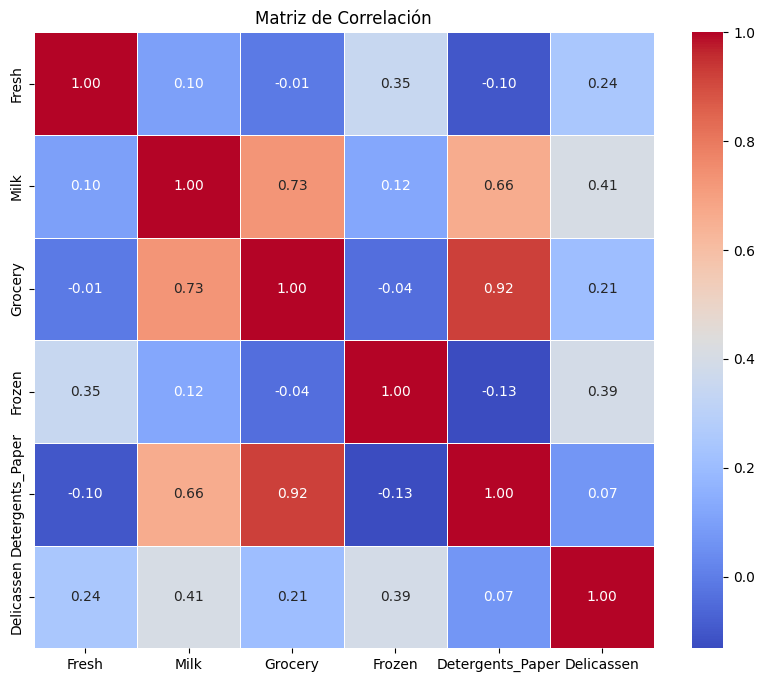

In [6]:
# Calcular la matriz de correlación
correlation_matrix = df.drop(['Channel', 'Region'], axis=1).corr()

# Visualizar la matriz de correlación con un heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [7]:
# Estandarizacion de datos
# Eliminar columnas no numéricas para la estandarización
scaled_features = df.drop(['Channel', 'Region'], axis=1)

# Estandarizar las características
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_features)

# Crear un DataFrame con las características estandarizadas
df_scaled = pd.DataFrame(scaled_data, columns=scaled_features.columns)

# Ver las primeras filas de los datos estandarizados
print(df_scaled.head())

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.052933  0.523568 -0.041115 -0.589367         -0.043569   -0.066339
1 -0.391302  0.544458  0.170318 -0.270136          0.086407    0.089151
2 -0.447029  0.408538 -0.028157 -0.137536          0.133232    2.243293
3  0.100111 -0.624020 -0.392977  0.687144         -0.498588    0.093411
4  0.840239 -0.052396 -0.079356  0.173859         -0.231918    1.299347


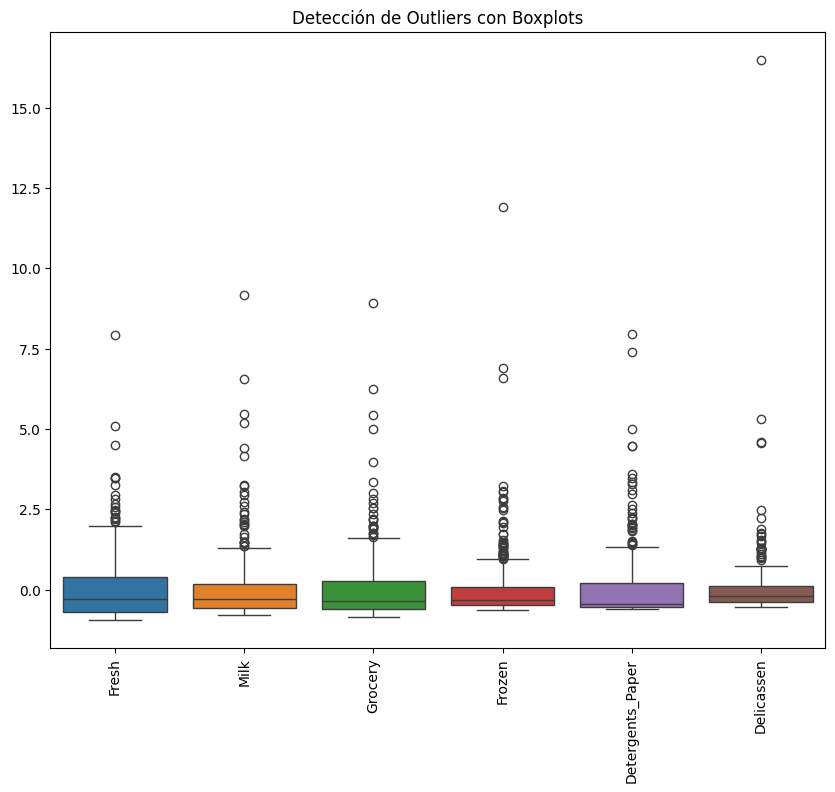

In [8]:
# Crear boxplots para detectar outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_scaled)
plt.title('Detección de Outliers con Boxplots')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Definir los límites superiores e inferiores del IQR para cada columna
Q1 = df_scaled.quantile(0.25)
Q3 = df_scaled.quantile(0.75)
IQR = Q3 - Q1

# Eliminar los outliers basados en el IQR
df_no_outliers = df_scaled[~((df_scaled < (Q1 - 1.5 * IQR)) | (df_scaled > (Q3 + 1.5 * IQR))).any(axis=1)]

# Ver el número de filas después de eliminar outliers
print(f"Filas después de eliminar outliers: {df_no_outliers.shape[0]}")

# Verificar si existen valores nulos
print(df_no_outliers.isnull().sum())

Filas después de eliminar outliers: 332
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


3. Aplicación de DBSCAN:
  * Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).
  * Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.
  * Determina cuáles son los outliers identificados por DBSCAN y visualiza cómo se distribuyen en relación con los clusters formados.

In [12]:
# Aplicar DBSCAN con un valor inicial de epsilon (ε) y min_samples
epsilon = 0.5  # Distancia máxima para los puntos vecinos
min_samples = 5  # Mínimo de puntos para formar un cluster

# Ejecutar DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_no_outliers)

# Añadir los clusters al DataFrame
df_no_outliers['Cluster'] = clusters

# Ver el número de clusters identificados y el número de outliers (puntos con -1)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_outliers = list(clusters).count(-1)
print(f"Total de clusters formados: {n_clusters}")
print(f"Total de outliers identificados: {n_outliers}")

Total de clusters formados: 1
Total de outliers identificados: 80


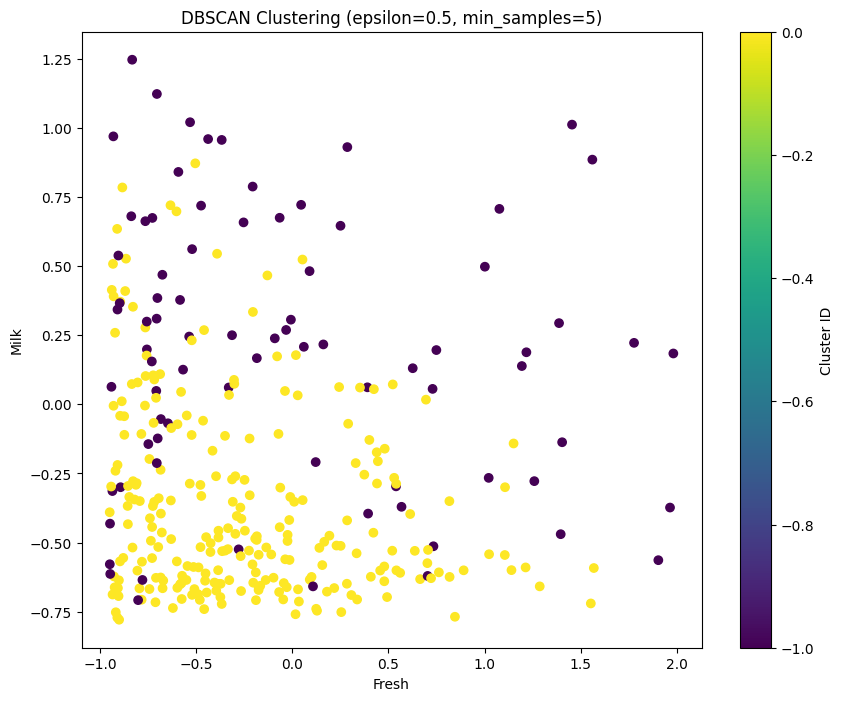

In [13]:
# Visualización de los clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_no_outliers.iloc[:, 0], df_no_outliers.iloc[:, 1], c=df_no_outliers['Cluster'], cmap='viridis', marker='o')
plt.title(f"DBSCAN Clustering (epsilon={epsilon}, min_samples={min_samples})")
plt.xlabel(df_no_outliers.columns[0])
plt.ylabel(df_no_outliers.columns[1])
plt.colorbar(label='Cluster ID')
plt.show()


epsilon=0.5, min_samples=5 -> Clusters: 1, Outliers: 80


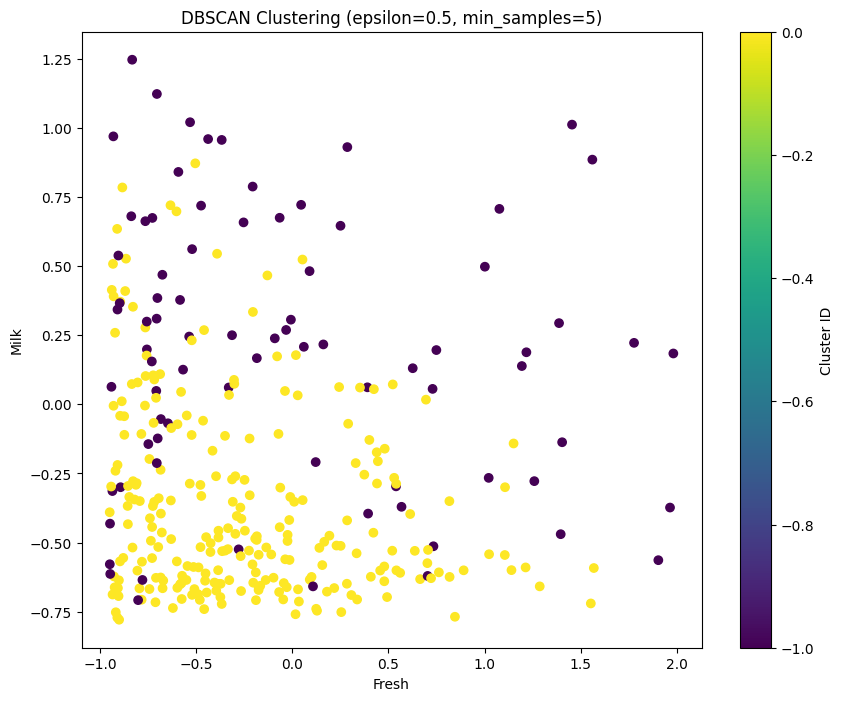

epsilon=1.0, min_samples=5 -> Clusters: 2, Outliers: 6


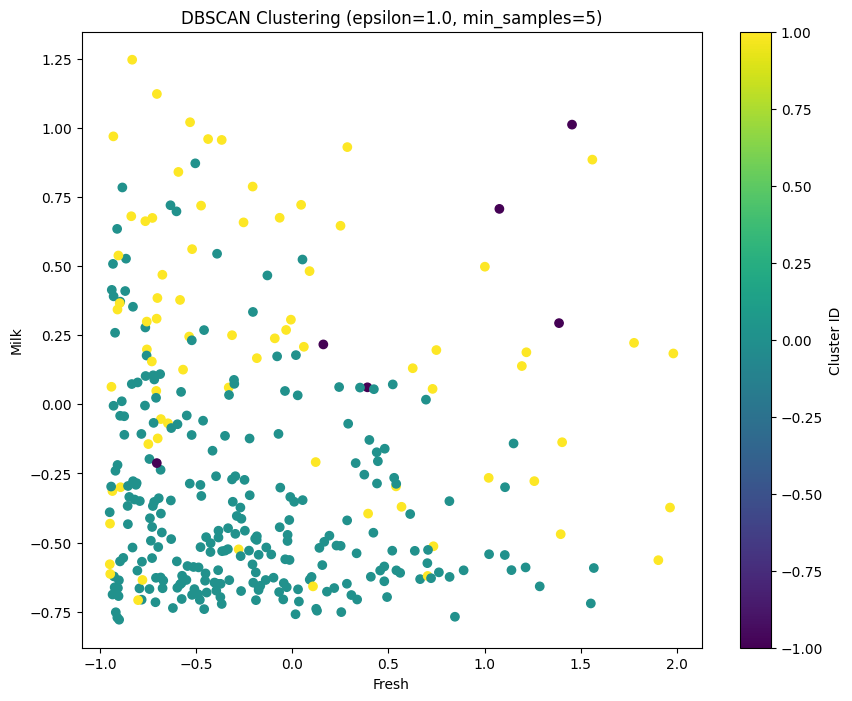

epsilon=0.5, min_samples=10 -> Clusters: 2, Outliers: 124


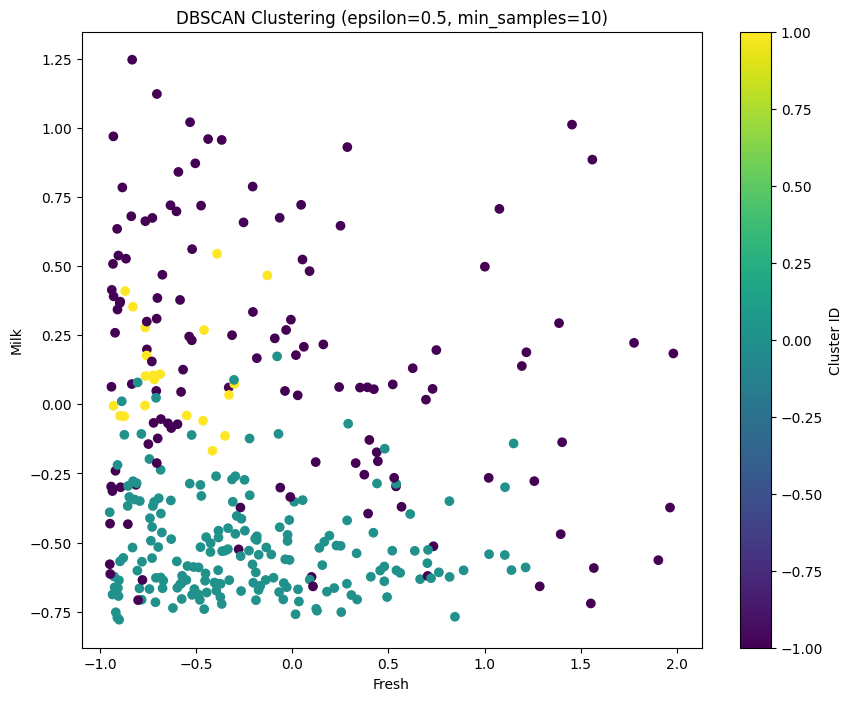

epsilon=1.0, min_samples=3 -> Clusters: 3, Outliers: 3


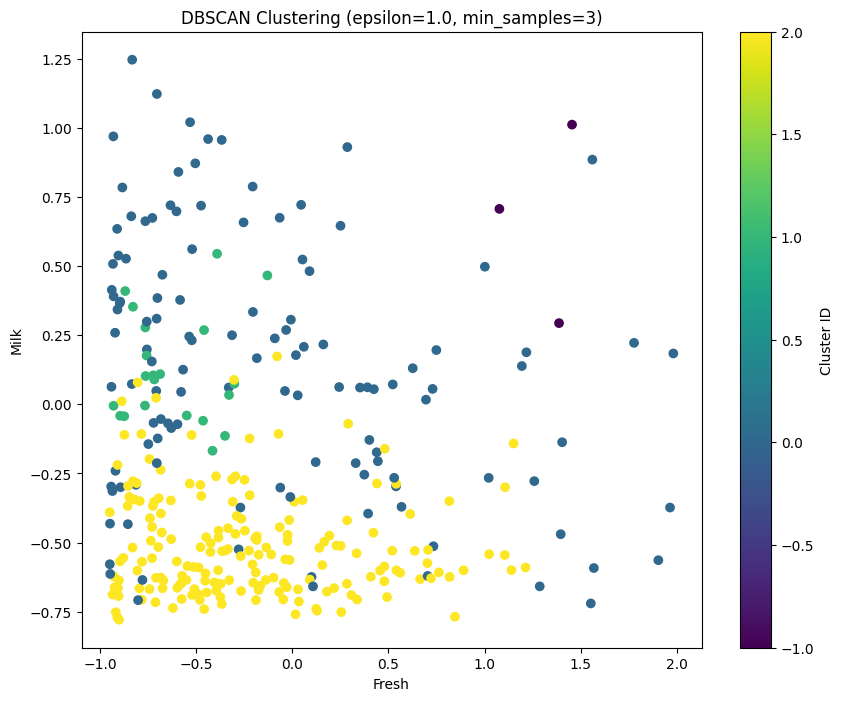

In [14]:
# Probar con diferentes valores de epsilon y min_samples
params = [(0.5, 5), (1.0, 5), (0.5, 10), (1.0, 3)]

for eps, min_samp in params:
    dbscan = DBSCAN(eps=eps, min_samples=min_samp)
    clusters = dbscan.fit_predict(df_no_outliers)
    df_no_outliers['Cluster'] = clusters

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_outliers = list(clusters).count(-1)
    print(f"epsilon={eps}, min_samples={min_samp} -> Clusters: {n_clusters}, Outliers: {n_outliers}")
    
    # Graficar los resultados
    plt.figure(figsize=(10, 8))
    plt.scatter(df_no_outliers.iloc[:, 0], df_no_outliers.iloc[:, 1], c=df_no_outliers['Cluster'], cmap='viridis', marker='o')
    plt.title(f"DBSCAN Clustering (epsilon={eps}, min_samples={min_samp})")
    plt.xlabel(df_no_outliers.columns[0])
    plt.ylabel(df_no_outliers.columns[1])
    plt.colorbar(label='Cluster ID')
    plt.show()


4. Visualización de clusters y outliers:
  * Visualiza los clusters formados por DBSCAN en gráficos de dispersión. Utiliza diferentes colores para representar los clusters y marca los outliers con un color distintivo para hacer visible su presencia.
  * Discute la estructura de los clusters encontrados. ¿Hay alguna correlación entre las variables y los clusters? ¿Cómo se distribuyen los outliers en comparación con los datos agrupados?

        Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
141  1.454823  1.011360 -0.291000 -0.567301         -0.594338   -0.026579   
253  1.387301  0.293643  0.949682 -0.544411         -0.528825   -0.047524   
403  1.077001  0.706693 -0.352629 -0.607308         -0.472341   -0.439089   

     Cluster  
141       -1  
253       -1  
403       -1  
     Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    

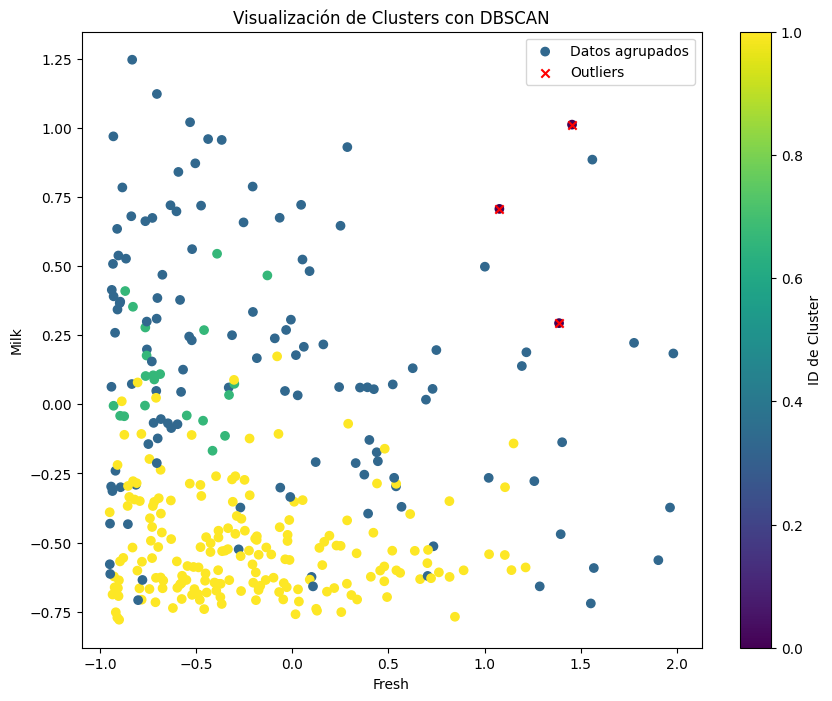

In [20]:
# Visualización de los clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_no_outliers.iloc[:, 0], df_no_outliers.iloc[:, 1], 
            c=df_no_outliers['Cluster'], cmap='viridis', marker='o', label='Datos agrupados')

# Destacar los outliers
outliers = df_no_outliers[df_no_outliers['Cluster'] == -1]
plt.scatter(outliers.iloc[:, 0], outliers.iloc[:, 1], color='red', marker='x', label='Outliers')
print(outliers)
print(df)
plt.title('Visualización de Clusters con DBSCAN')
plt.xlabel(df_no_outliers.columns[0])
plt.ylabel(df_no_outliers.columns[1])
plt.colorbar(label='ID de Cluster')
plt.legend()
plt.show()


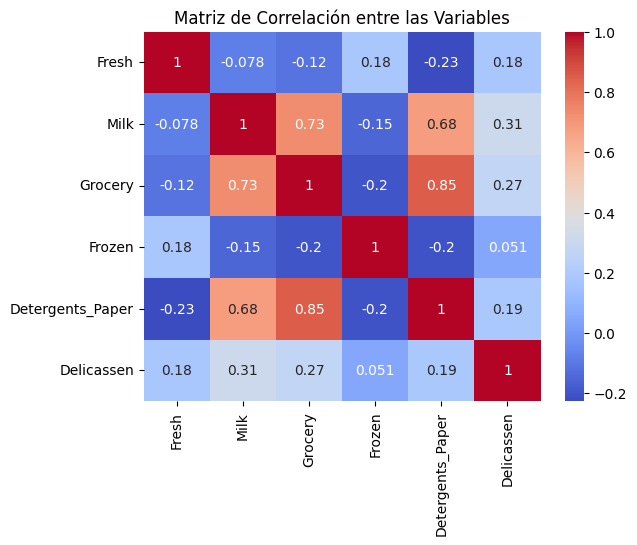

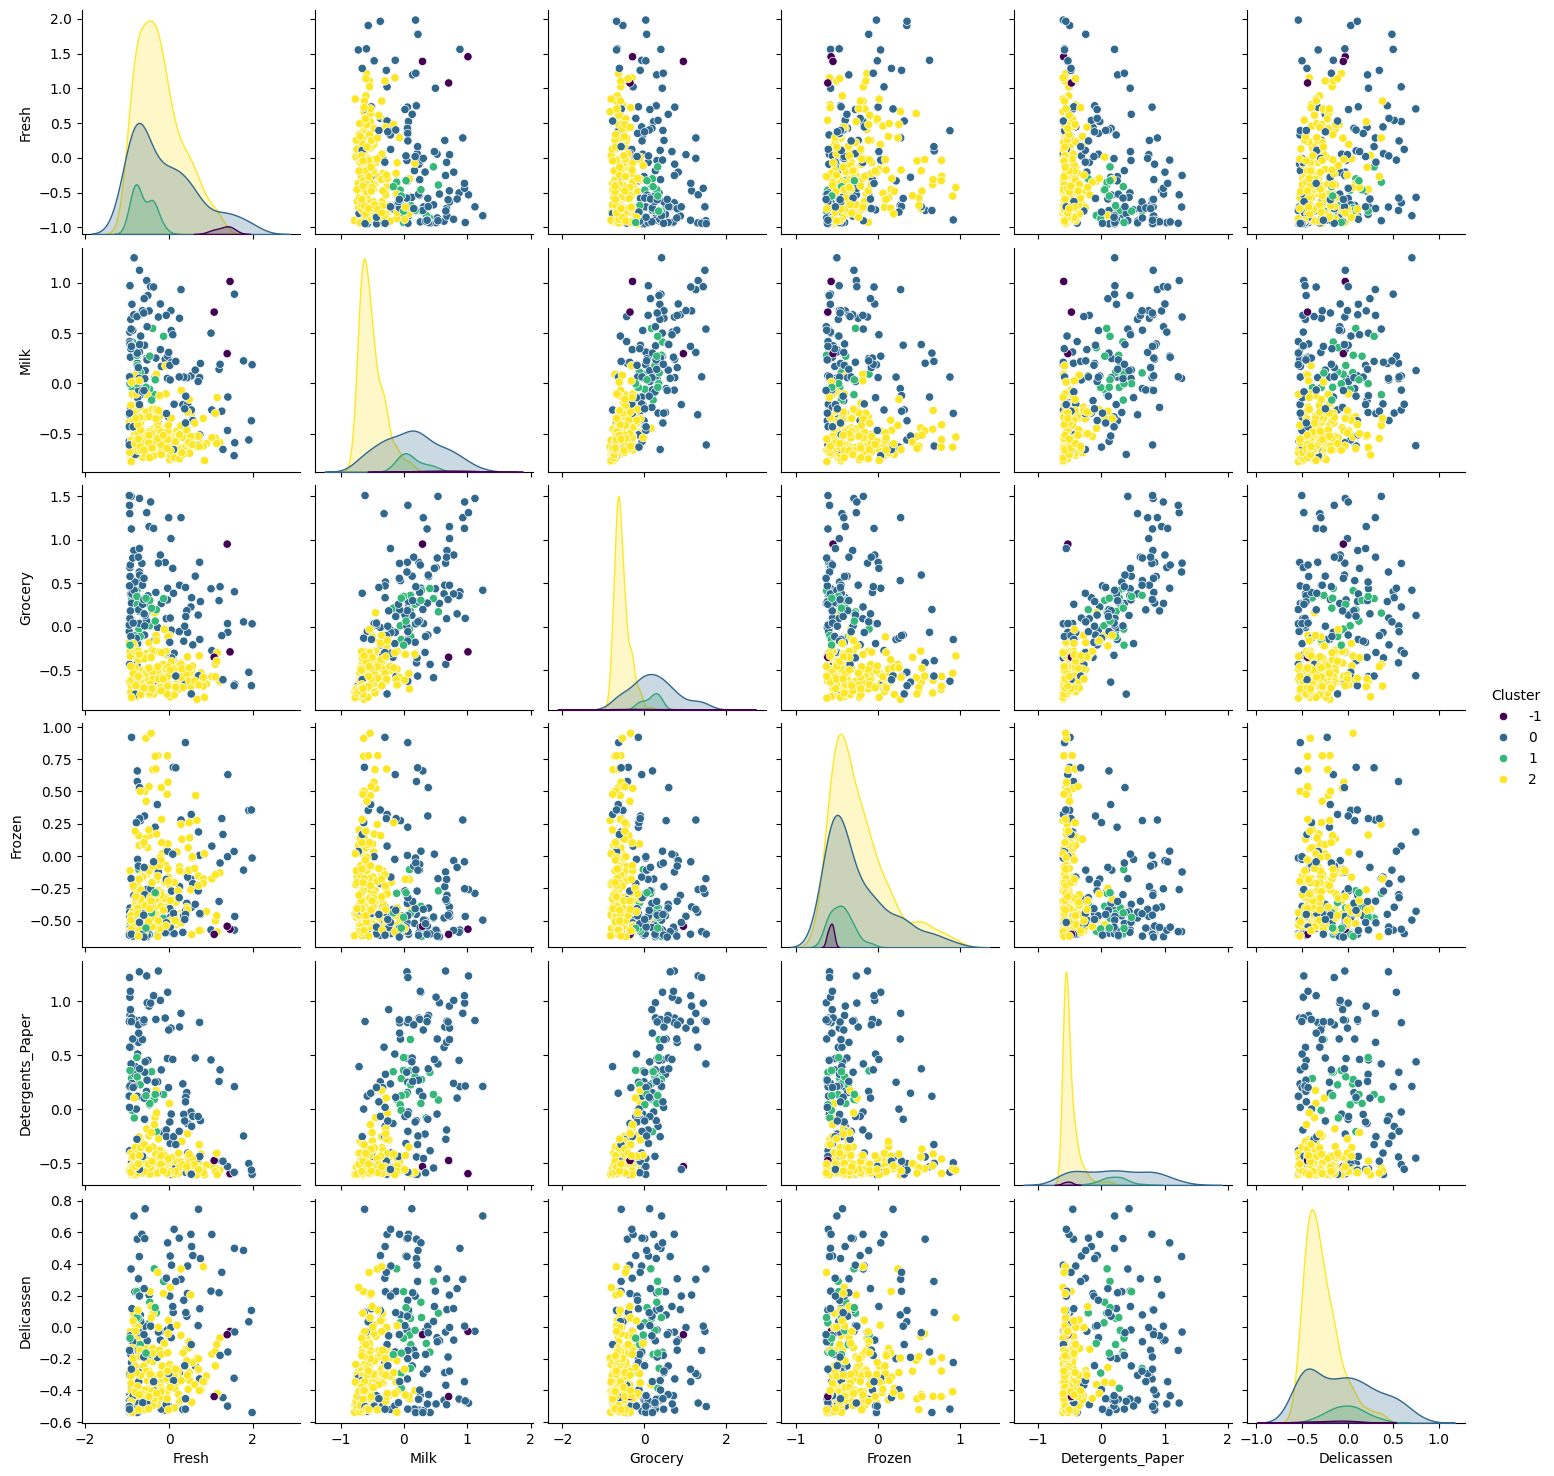

In [17]:
# Mostrar una matriz de correlación para las variables
corr_matrix = df_no_outliers.drop(columns='Cluster').corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre las Variables')
plt.show()

# Distribución de las variables en cada cluster
sns.pairplot(df_no_outliers, hue='Cluster', palette='viridis')
plt.show()

5. Interpretación de resultados:
  * Evalúa la calidad del agrupamiento. DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano.
  * Discute la naturaleza de los outliers detectados. ¿Son clientes únicos con comportamientos inusuales? ¿Podrían estos clientes representar oportunidades comerciales o riesgos?

### Posibles Interpretaciones:
* Clientes con comportamientos inusuales: Estos outliers pueden ser clientes que realizan compras inusuales en ciertas categorías (como frescos, lácteos o productos de limpieza). Tal vez compran en grandes cantidades en una categoría específica, lo que los hace destacar de los demás clientes.
* Oportunidades comerciales: Los outliers podrían representar clientes valiosos con necesidades o comportamientos particulares. Por ejemplo, si se agrupan alrededor de ciertos productos específicos, podrían ser identificados como un nicho para ofrecer productos personalizados.
* Riesgos: Si los outliers representan compras fraudulentas o errores en los datos (como registros incorrectos), podrían indicar la necesidad de revisar o filtrar los datos antes de hacer análisis adicionales. Sin embargo, es importante verificar si estos outliers realmente corresponden a datos legítimos.

### Interpretación de los Clusters
* Distribución de los clusters: Los clusters formados por DBSCAN deberían mostrar una distribución lógica de clientes con características similares (por ejemplo, clientes que compran cantidades similares de productos). Puedes analizar las características de los clientes dentro de cada cluster para entender mejor qué los hace similares.
* Relación entre las variables y los clusters: Es posible que ciertos productos (como Grocery, Fresh, Milk, Frozen) sean más comprados por ciertos grupos de clientes. Si los clusters están formados principalmente por clientes con compras similares en estas categorías, eso sugiere que DBSCAN ha logrado identificar grupos con comportamientos de compra similares.
* Tamaño de los clusters: Si el número de clusters es bajo, eso puede ser indicativo de que los datos tienen una estructura simple y no hay muchos patrones complejos. Si el número de clusters es alto, puede reflejar una gran diversidad en los comportamientos de los clientes.